In [1]:
pip install --upgrade qiskit qiskit-finance numpy pandas matplotlib


Note: you may need to restart the kernel to use updated packages.


Stock Covariance Matrix:
        AAPL      GOOGL       MSFT       TSLA
0  32.929644  35.190928  10.995452  26.686611
1  35.190928  75.301763   2.828439  28.476003
2  10.995452   2.828439  20.612460   8.274859
3  26.686611  28.476003   8.274859  32.463091

Portfolio Optimization Problem:
minimize 16.464822152938986*x_0^2 + 35.19092772257926*x_0*x_1 + 10.995452117508307*x_0*x_2 + 26.68661076715245*x_0*x_3 + 37.650881276848885*x_1^2 + 2.8284390279535705*x_1*x_2 + 28.47600271635904*x_1*x_3 + 10.306230193772645*x_2^2 + 8.27485943694024*x_2*x_3 + 16.231545395904465*x_3^2 - 26.4506587282795*x_0 - 35.44928300514741*x_1 - 10.677802742486852*x_2 - 23.975140928065166*x_3 (4 variables, 1 constraints, 'Portfolio optimization')

Optimal Portfolio Allocation: []


/var/folders/jq/84t05qsn7f18kfct81_nbrb40000gn/T/ipykernel_18933/2966150584.py:62: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


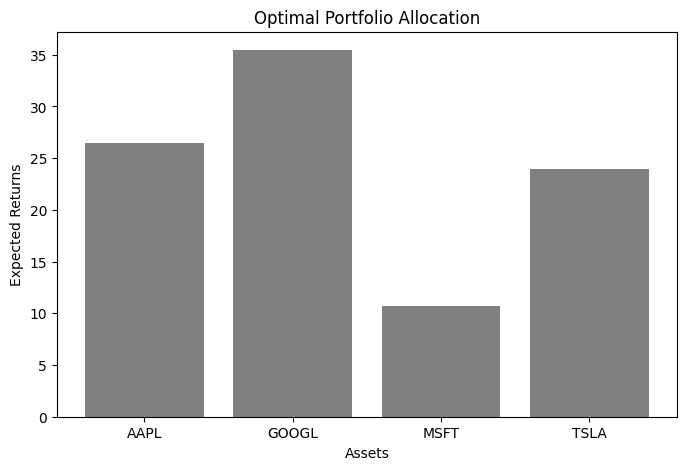

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.optimizers import COBYLA

# ✅ Step 1: Generate Synthetic Financial Data
num_assets = 4

# Define the date range correctly
start = datetime(2022, 1, 1)
end = datetime(2023, 1, 1)

# Initialize Random Data Provider
data_provider = RandomDataProvider(
    tickers=['AAPL', 'GOOGL', 'MSFT', 'TSLA'],
    start=start,
    end=end,
    seed=42
)

data_provider.run()
stock_data = data_provider.get_covariance_matrix()
expected_returns = np.mean(stock_data, axis=0)

# Convert to Pandas DataFrame for visualization
df = pd.DataFrame(stock_data, columns=['AAPL', 'GOOGL', 'MSFT', 'TSLA'])
print("Stock Covariance Matrix:")
print(df)

# ✅ Step 2: Define Portfolio Optimization Problem
risk_factor = 0.5  # Adjust risk tolerance
budget = 2  # Number of assets to select

# Define Portfolio Optimization
portfolio = PortfolioOptimization(
    expected_returns=expected_returns,
    covariances=stock_data,
    risk_factor=risk_factor,
    budget=budget
)

# Convert to Quadratic Program
quadratic_program = portfolio.to_quadratic_program()
print("\nPortfolio Optimization Problem:")
print(quadratic_program)

# ✅ Step 3: Solve Using SamplingVQE
# Define Variational Ansatz (Two-Local circuit)
ansatz = TwoLocal(rotation_blocks=["ry", "rz"], entanglement_blocks="cz")

# Define optimizer
optimizer = COBYLA(maxiter=100)

# Initialize the Sampler primitive
sampler = Sampler()

# Set up SamplingVQE algorithm
sampling_vqe = SamplingVQE(sampler=sampler, ansatz=ansatz, optimizer=optimizer)

# Solve Portfolio Optimization Problem using Minimum Eigen Optimizer
qaoa = MinimumEigenOptimizer(sampling_vqe)
result = qaoa.solve(quadratic_program)

# ✅ Step 4: Interpret Results
optimal_portfolio = portfolio.interpret(result)
optimal_portfolio = np.atleast_1d(optimal_portfolio)  # ✅ Ensure 1D array

# Select indices of chosen assets
selected_assets = np.where(optimal_portfolio == 1)[0]
selected_tickers = [df.columns[i] for i in selected_assets]

# Print selected assets
print(f"\nOptimal Portfolio Allocation: {selected_tickers}")

# ✅ Step 5: Visualize Optimal Portfolio Selection
plt.figure(figsize=(8, 5))
plt.bar(df.columns, expected_returns, color=['green' if i in selected_assets else 'gray' for i in range(len(df.columns))])
plt.xlabel("Assets")
plt.ylabel("Expected Returns")
plt.title("Optimal Portfolio Allocation")
plt.show()
